In [1]:
import torch

In [2]:

%load_ext autoreload
%autoreload 2


In [3]:

# Create a matrix
matrix = torch.randn(1000, 1000, device='cuda')  # Use the GPU by specifying device='cuda'

# Perform matrix inversion
inverted_matrix = torch.linalg.inv(matrix)

# Print the result
print(inverted_matrix)


tensor([[-0.0231,  0.1174, -0.2356,  ..., -0.3596, -0.1456,  0.3267],
        [ 0.0868, -0.2572,  0.4568,  ...,  0.7111,  0.3177, -0.6661],
        [-0.0065, -0.1492,  0.1658,  ...,  0.2848,  0.1587, -0.1931],
        ...,
        [-0.0306, -0.1874,  0.2086,  ...,  0.3709,  0.1669, -0.2222],
        [ 0.0552,  0.2207, -0.2387,  ..., -0.4286, -0.2293,  0.2161],
        [-0.0252,  0.0467, -0.0792,  ..., -0.1193, -0.0335,  0.1453]],
       device='cuda:0')


In [4]:
from hamiltonians import Central,CentralBdG
# Example usage
Ny = 3
Nx = 4
t_y = torch.tensor(2.0*1j, dtype=torch.complex64)
t_x = torch.tensor(1.0, dtype=torch.complex64)
Delta = torch.tensor(0, dtype=torch.complex64)
# Create an instance of the modified Central Hamiltonian
central_hamiltonian = CentralBdG(Ny=Ny, Nx=Nx, t_y=t_y, t_x=t_x,Delta=Delta)
print(central_hamiltonian)

CentralBdG(Ny=3, Nx=4, t_y=2j, t_x=(1+0j), Delta=0j)


Below checked batched E for lead_decimation.

In [4]:
from utils.lead_decimation import lead_decimation
from time import time
# Define parameters
t = torch.tensor([[20.0, 0.0], [0.0, 20.0]],dtype=torch.complex64,device='cpu' if torch.cuda.is_available() else 'cpu')
epsilon0 = torch.tensor([[0.0, 20.0], [20.0, 0.0]], dtype=torch.complex64, device=t.device)
E = torch.tensor([0.1,0.2])
mu = torch.tensor(20)
temperature = torch.tensor(1e-6)
particle_type = 'e'

# Time the function execution
start_time = time()

# Call lead_decimation to calculate Green's functions
gLr, gLa, gLless, gLmore = lead_decimation(E, t, epsilon0, mu, temperature, particle_type)
elapsed_time = time() - start_time
# Display results
print('Retarded Greens function:')
print(gLr)

print('Advanced Greens function:')
print(gLa)

print('Lesser Greens function:')
print(gLless)

print('Greater Greens function:')
print(gLmore)

print(f'Elapsed time: {elapsed_time:.4f} seconds')

Retarded Greens function:
tensor([[[ 0.0001-4.3289e-02j, -0.0250-7.2161e-05j],
         [-0.0250-7.2175e-05j,  0.0001-4.3289e-02j]],

        [[ 0.0002-4.3288e-02j, -0.0250-1.4429e-04j],
         [-0.0250-1.4446e-04j,  0.0002-4.3288e-02j]]])
Advanced Greens function:
tensor([[[ 0.0001+4.3289e-02j, -0.0250+7.2175e-05j],
         [-0.0250+7.2161e-05j,  0.0001+4.3289e-02j]],

        [[ 0.0002+4.3288e-02j, -0.0250+1.4446e-04j],
         [-0.0250+1.4429e-04j,  0.0002+4.3288e-02j]]])
Lesser Greens function:
tensor([[[ 0.0000e+00+0.0866j,  2.0489e-08+0.0001j],
         [-2.0489e-08+0.0001j,  0.0000e+00+0.0866j]],

        [[ 0.0000e+00+0.0866j,  2.9802e-08+0.0003j],
         [-2.9802e-08+0.0003j,  0.0000e+00+0.0866j]]])
Greater Greens function:
tensor([[[0.+0.j, 0.-0.j],
         [0.+0.j, 0.+0.j]],

        [[0.+0.j, 0.-0.j],
         [0.+0.j, 0.+0.j]]])
Elapsed time: 0.0291 seconds


Check Giv_central for batched E

In [3]:
import torch
from hamiltonians import CentralBdG
from greens_functions import construct_ginv_central
# Define parameters for the central region
E = torch.tensor([0.1,0.2])
eta = torch.tensor(1e-2)
Ny = 2  # Number of lattice sites in the y-direction
Nx = 2  # Number of lattice sites in the x-direction
t_y = torch.tensor(2.0, dtype=torch.complex64)  # Hopping parameter in y-direction
t_x = torch.tensor(1.0, dtype=torch.complex64)  # Hopping parameter in x-direction
Delta = torch.tensor(0, dtype=torch.complex64)  # Pairing potential for BdG

# Create CentralBdG instance
central_hamiltonian = CentralBdG(Ny=Ny, Nx=Nx, t_y=t_y, t_x=t_x, Delta=Delta)
H_BdG = central_hamiltonian.H_full_BdG  # Get the Hamiltonian matri
ginc=construct_ginv_central(H_BdG, E, eta)
print(ginc[0])
print(ginc[1])
# This result need to be compare with Matlab

tensor([[ 0.1000+0.0100j,  0.0000+0.0000j, -2.0000+0.0000j,  0.0000+0.0000j,
         -1.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,
          0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,
          0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j],
        [ 0.0000+0.0000j,  0.1000+0.0100j,  0.0000+0.0000j,  2.0000+0.0000j,
          0.0000+0.0000j,  1.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,
          0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,
          0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j],
        [-2.0000+0.0000j,  0.0000+0.0000j,  0.1000+0.0100j,  0.0000+0.0000j,
          0.0000+0.0000j,  0.0000+0.0000j, -1.0000+0.0000j,  0.0000+0.0000j,
          0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,
          0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j],
        [ 0.0000+0.0000j,  2.0000+0.0000j,  0.0000+0.0000j,  0.1000+0.010

In [16]:
import torch
import scipy.io as sio
from hamiltonians.Central import CentralBdG
from hamiltonians.Lead import Lead
from greens_functions.construct_ginv_total import construct_ginv_total
E = torch.tensor([0.1,-10])
eta = torch.tensor(1e-2)
# Define parameters for the central region
Ny = 4  # Number of lattice sites in the y-direction
Nx = 3  # Number of lattice sites in the x-direction
t_y = torch.tensor(2.0, dtype=torch.complex64)  # Hopping parameter in y-direction
t_x = torch.tensor(1.0, dtype=torch.complex64)  # Hopping parameter in x-direction
Delta = torch.tensor(0, dtype=torch.complex64)  # Pairing potential for BdG

# Create CentralBdG instance
central_hamiltonian = CentralBdG(Ny=Ny, Nx=Nx, t_y=t_y, t_x=t_x, Delta=Delta)
H_BdG = central_hamiltonian.H_full_BdG  # Get the Hamiltonian matri

# Define parameters for the leads as torch tensors
mu_values = torch.tensor([20.0, -20.0], dtype=torch.float32)  # Chemical potentials for each lead
t_lead_central = torch.tensor(1.0, dtype=torch.float32)  # Coupling strength between lead and central region
t_lead = torch.tensor(20.0, dtype=torch.float32)  # Hopping parameter within the lead
temperature = torch.tensor(1e-6, dtype=torch.float32)  # Temperature

# Create lead objects
leads_info = [Lead(mu=mu, t_lead_central=t_lead_central, temperature=temperature, Ny=Ny, t_lead=t_lead) for mu in mu_values]

# Set positions for leads, shifting them by one site for python range 0
leads_info[0].position = torch.arange(Ny)
leads_info[1].position = leads_info[0].position + Ny * (Nx - 1)


# Construct the total G inverse matrix
Ginv_total = construct_ginv_total(H_BdG, E, eta, leads_info)
print(Ginv_total.size())



torch.Size([2, 80, 80])


In [17]:
import torch
from scipy.io import savemat

# Assuming Ginv_total is of shape (batch_size, N_total, N_total)
Ginv_total_first_E = Ginv_total[1].detach().cpu().numpy()

# Save to .mat file
savemat('Ginv_total_python.mat', {'Ginv_total': Ginv_total_first_E})

autograd calc

In [3]:
import torch
import scipy.io as sio
from hamiltonians.Central import CentralBdG
from hamiltonians.Lead import Lead
from greens_functions.construct_ginv_total import construct_ginv_total

# Define parameters for the central region
Ny = 1  # Number of lattice sites in the y-direction
Nx = 4  # Number of lattice sites in the x-direction
t_y = torch.tensor(1.0, dtype=torch.complex64, device='cuda')  # Hopping parameter in y-direction
t_x = torch.tensor(1.0, dtype=torch.complex64, device='cuda')  # Hopping parameter in x-direction
Delta = torch.tensor(0, dtype=torch.complex64, device='cuda')  # Pairing potential for BdG

# Create CentralBdG instance
central_hamiltonian = CentralBdG(Ny=Ny, Nx=Nx, t_y=t_y, t_x=t_x, Delta=Delta)
H_BdG = central_hamiltonian.H_full_BdG  # Get the Hamiltonian matrix on CUDA
# Save H_BdG[0] to .mat file
sio.savemat('H_full_BdG_python.mat', {'H_full_BdG_python': H_BdG.cpu().detach().numpy()})

# Define parameters for the leads as torch tensors
mu_values = torch.tensor([20.0, 0.0], dtype=torch.float32, device='cuda')  # Chemical potentials for each lead
t_lead_central = torch.tensor(1.0, dtype=torch.float32, device='cuda')  # Coupling strength between lead and central region
t_lead = torch.tensor(20.0, dtype=torch.float32, device='cuda')  # Hopping parameter within the lead
temperature = torch.tensor(1e-6, dtype=torch.float32, device='cuda')  # Temperature

# Create lead objects
leads_info = [
    Lead(mu=mu, t_lead_central=t_lead_central, temperature=temperature, Ny=Ny, t_lead=t_lead)
    for mu in mu_values
]

# Set positions for leads, shifting them by one site for python range 0
leads_info[0].position = torch.arange(Ny, device='cuda')
leads_info[1].position = leads_info[0].position + Ny * (Nx - 1)

# Define energy and small imaginary part for regularization
E = torch.linspace(0.61, 0.63, steps=2, dtype=torch.float32, device='cuda')  # Energy values on CUDA
eta = torch.tensor(1e-8, dtype=torch.float32, device='cuda')  # Small imaginary part for regularization on CUDA

# Construct the total G inverse matrix
Ginv_total = construct_ginv_total(H_BdG, E, eta, leads_info)

# Print the resulting G inverse matrix
print("Ginv_total:")
print(Ginv_total)

# Save Ginv_total to a .mat file
sio.savemat('Ginv_total_python.mat', {'Ginv_total': Ginv_total[0].cpu().detach().numpy()})

# Print the resulting G inverse matrix
print("Ginv_total:")
print(Ginv_total)


Ginv_total:
tensor([[[ 6.1000e-01+1.0000e-08j,  0.0000e+00+0.0000e+00j,
          -1.0000e+00+0.0000e+00j,  ...,
           0.0000e+00+0.0000e+00j,  0.0000e+00+0.0000e+00j,
           0.0000e+00+0.0000e+00j],
         [ 0.0000e+00+0.0000e+00j,  6.1000e-01+1.0000e-08j,
           0.0000e+00+0.0000e+00j,  ...,
           0.0000e+00+0.0000e+00j,  0.0000e+00+0.0000e+00j,
           0.0000e+00+0.0000e+00j],
         [-1.0000e+00+0.0000e+00j,  0.0000e+00+0.0000e+00j,
           6.1000e-01+1.0000e-08j,  ...,
           0.0000e+00+0.0000e+00j,  0.0000e+00+0.0000e+00j,
           0.0000e+00+0.0000e+00j],
         ...,
         [ 0.0000e+00-0.0000e+00j,  0.0000e+00-0.0000e+00j,
           0.0000e+00-0.0000e+00j,  ...,
           3.0505e-01+2.0003e+01j,  0.0000e+00+0.0000e+00j,
          -3.6421e-08+4.0005e+01j],
         [ 0.0000e+00-0.0000e+00j,  0.0000e+00-0.0000e+00j,
           0.0000e+00-0.0000e+00j,  ...,
           0.0000e+00+0.0000e+00j,  3.0505e-01-2.0003e+01j,
           0.0000e+00+0.0

In [4]:
from calculations.calculation_cf_autograd import calculation_cf_autograd
calculation_cf_autograd(H_BdG, E, eta, leads_info, max_derivative_order=2)

{'gen_func_values_real': tensor([14.8515, 14.9642]),
 'gen_func_values_imag': tensor([-1.2575e-08, -2.9883e-08]),
 'derivatives': {'order_1': tensor([[-0.9534,  0.9534],
          [-0.9012,  0.9012]]),
  'order_2': tensor([[[-0.0444,  0.0444],
           [ 0.0444, -0.0444]],
  
          [[-0.0890,  0.0890],
           [ 0.0890, -0.0890]]])}}

In [6]:
import torch

if torch.cuda.is_available():
    # Get the current device
    device = torch.cuda.current_device()
    
    # Get the total and available memory
    total_memory = torch.cuda.get_device_properties(device).total_memory
    reserved_memory = torch.cuda.memory_reserved(device)
    allocated_memory = torch.cuda.memory_allocated(device)
    free_memory = reserved_memory - allocated_memory
    
    print(f"Total memory: {total_memory / (1024 ** 3):.2f} GB")
    print(f"Reserved memory: {reserved_memory / (1024 ** 3):.2f} GB")
    print(f"Allocated memory: {allocated_memory / (1024 ** 3):.2f} GB")
    print(f"Free memory: {free_memory / (1024 ** 3):.2f} GB")
else:
    print("CUDA is not available.")

Total memory: 12.00 GB
Reserved memory: 0.04 GB
Allocated memory: 0.02 GB
Free memory: 0.03 GB


In [1]:
import torch
import scipy.io as sio
from hamiltonians.Central import CentralBdG
from hamiltonians.Lead import Lead
from greens_functions.construct_ginv_total import construct_ginv_total
from calculations.calculation_cf_autograd import calculation_cf_autograd

# Define parameters for the central region
Ny = 1  # Number of lattice sites in the y-direction
Nx = 4  # Number of lattice sites in the x-direction
t_y = torch.tensor(1.0, dtype=torch.complex64, device='cuda')  # Hopping parameter in y-direction
t_x = torch.tensor(1.0, dtype=torch.complex64, device='cuda')  # Hopping parameter in x-direction
Delta = torch.tensor(0, dtype=torch.complex64, device='cuda')  # Pairing potential for BdG

# Create CentralBdG instance with funcDevice='cuda'
central_hamiltonian = CentralBdG(Ny=Ny, Nx=Nx, t_y=t_y, t_x=t_x, Delta=Delta)
H_BdG = central_hamiltonian.H_full_BdG  # Get the Hamiltonian matrix on CUDA

# Define parameters for the leads as torch tensors
mu_values = torch.tensor([20.0, 0.0], dtype=torch.float32, device='cuda')  # Chemical potentials for each lead
t_lead_central = torch.tensor(1.0, dtype=torch.float32, device='cuda')  # Coupling strength between lead and central region
t_lead = torch.tensor(20.0, dtype=torch.float32, device='cuda')  # Hopping parameter within the lead
temperature = torch.tensor(1e-6, dtype=torch.float32, device='cuda')  # Temperature

# Create lead objects
leads_info = [
    Lead(mu=mu, t_lead_central=t_lead_central, temperature=temperature, Ny=Ny, t_lead=t_lead)
    for mu in mu_values
]

# Set positions for leads, shifting them by one site for Python's 0-based indexing
leads_info[0].position = torch.arange(Ny, device='cuda')
leads_info[1].position = leads_info[0].position + Ny * (Nx - 1)

# Define energy and small imaginary part for regularization
E = torch.linspace(-3, 3, steps=300, dtype=torch.float32, device='cuda')  # Energy values on CUDA
eta = torch.tensor(1e-2, dtype=torch.float32, device='cuda')  # Small imaginary part for regularization on CUDA

# Process energy values in chunks
chunk_size = 10  # Define the chunk size
results_list = []

for start in range(0, E.size(0), chunk_size):
    end = min(start + chunk_size, E.size(0))
    chunked_E = E[start:end]
    
    # Call the calculation function for the current chunk
    results = calculation_cf_autograd(H_BdG, chunked_E, eta, leads_info, max_derivative_order=2)
    results_list.append(results)

# Combine results from all chunks
combined_results = {
    'gen_func_values_real': torch.cat([res['gen_func_values_real'] for res in results_list], dim=0),
    'gen_func_values_imag': torch.cat([res['gen_func_values_imag'] for res in results_list], dim=0),
    'derivatives': {}
}

# Combine derivatives
for order in results_list[0]['derivatives'].keys():
    combined_results['derivatives'][order] = torch.cat([res['derivatives'][order] for res in results_list], dim=0)

# Optionally, save or process the combined results
sio.savemat(f'calculation_results_size_Ny{Ny}_Nx{Nx}_chunkESize_{chunk_size}.mat', combined_results)

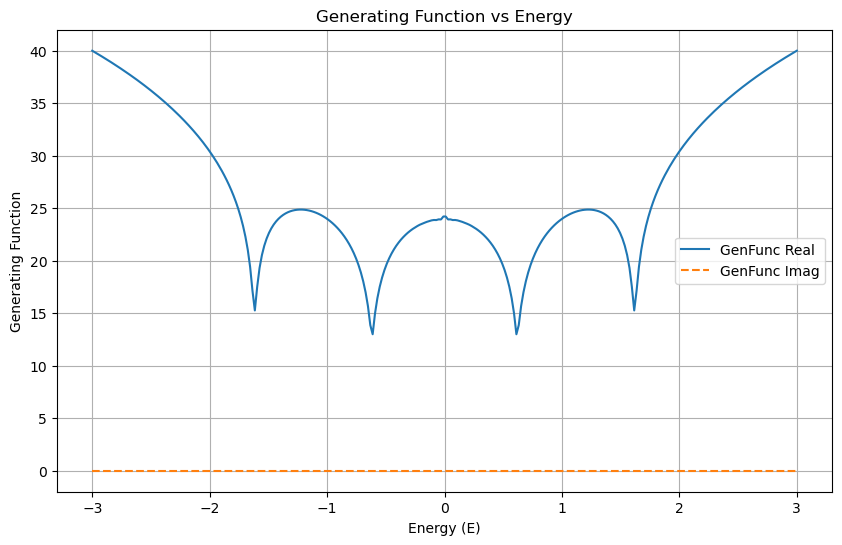

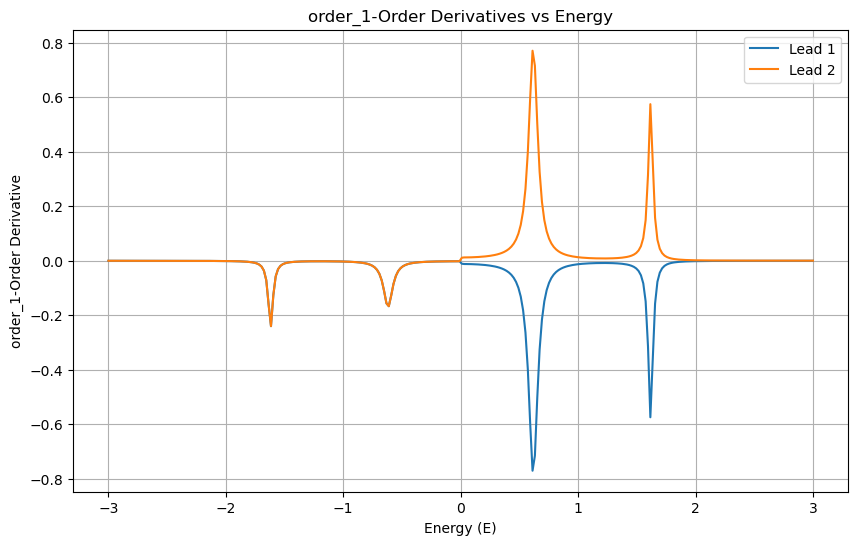

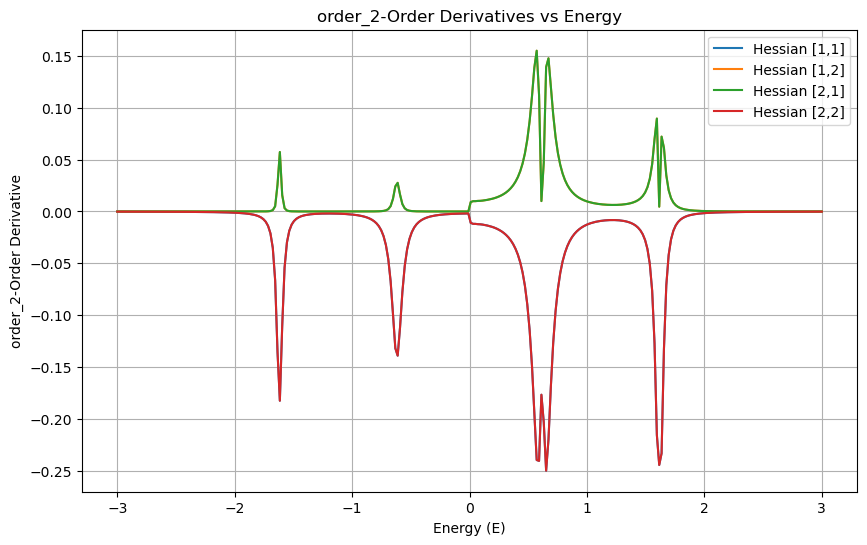

In [2]:
from dataplot.plot_all import plot_all
# Plot all results
plot_all(combined_results, E)

In [ ]:
import torch
import scipy.io as sio
from hamiltonians.Central import DisorderedCentralBdG
from hamiltonians.Lead import Lead
from greens_functions.construct_ginv_total import construct_ginv_total
from calculations.calculation_cf_autograd import calculation_cf_autograd

# Define parameters for the central region
Ny = 2  # Number of lattice sites in the y-direction
Nx = 10  # Number of lattice sites in the x-direction
t_y = torch.tensor(1.0, dtype=torch.complex64, device='cuda')  # Hopping parameter in y-direction
t_x = torch.tensor(1.0, dtype=torch.complex64, device='cuda')  # Hopping parameter in x-direction
Delta = torch.tensor(0, dtype=torch.complex64, device='cuda')  # Pairing potential for BdG
disorder_strength = torch.tensor(1.0, dtype=torch.float32, device='cuda')  # Disorder strength

# Create DisorderedCentralBdG instance
central_hamiltonian = DisorderedCentralBdG(
    Ny=Ny,
    Nx=Nx,
    t_y=t_y,
    t_x=t_x,
    Delta=Delta,
    disorder_strength=disorder_strength
)
H_BdG = central_hamiltonian.H_full_BdG  # Get the Hamiltonian matrix on CUDA

# Define parameters for the leads
mu_values = torch.tensor([20.0, -20.0], dtype=torch.float32, device='cuda')  # Chemical potentials
t_lead_central = torch.tensor(1.0, dtype=torch.float32, device='cuda')  # Coupling strength
t_lead = torch.tensor(20.0, dtype=torch.float32, device='cuda')  # Hopping within the lead
temperature = torch.tensor(1e-6, dtype=torch.float32, device='cuda')  # Temperature

# Create lead objects
leads_info = [
    Lead(mu=mu, t_lead_central=t_lead_central, temperature=temperature, Ny=Ny, t_lead=t_lead)
    for mu in mu_values
]

# Set positions for leads
leads_info[0].position = torch.arange(Ny, device='cuda')
leads_info[1].position = leads_info[0].position + Ny * (Nx - 1)

# Define energy and small imaginary part for regularization
E = torch.linspace(-3, 3, steps=300, dtype=torch.float32, device='cuda')
eta = torch.tensor(1e-2, dtype=torch.float32, device='cuda')

# Process energy values in chunks
chunk_size = 3
results_list = []

for start in range(0, E.size(0), chunk_size):
    end = min(start + chunk_size, E.size(0))
    chunked_E = E[start:end]
    
    # Call the calculation function for the current chunk
    results = calculation_cf_autograd(H_BdG, chunked_E, eta, leads_info, max_derivative_order=2)
    results_list.append(results)

# Combine results from all chunks
combined_results = {
    'gen_func_values_real': torch.cat([res['gen_func_values_real'] for res in results_list], dim=0),
    'gen_func_values_imag': torch.cat([res['gen_func_values_imag'] for res in results_list], dim=0),
    'derivatives': {}
}

# Combine derivatives
for order in results_list[0]['derivatives'].keys():
    combined_results['derivatives'][order] = torch.cat(
        [res['derivatives'][order] for res in results_list], dim=0
    )

# Save the combined results to a .mat file, including parameters in the filename
sio.savemat(
    f'calculation_results_size_Ny{Ny}_Nx{Nx}_chunkESize_{chunk_size}_disorder_{disorder_strength.item()}.mat',
    combined_results
)

In [ ]:
from dataplot.plot_all import plot_all
# Plot all results
plot_all(combined_results, E)

In [ ]:
import torch
import scipy.io as sio
from hamiltonians.Central import CentralBdG
from hamiltonians.Lead import Lead
from greens_functions.construct_ginv_total import construct_ginv_total

# Define parameters for the central region
Ny = 4  # Number of lattice sites in the y-direction
Nx = 3  # Number of lattice sites in the x-direction
t_y = torch.tensor(2.0, dtype=torch.complex64)  # Hopping parameter in y-direction
t_x = torch.tensor(1.0, dtype=torch.complex64)  # Hopping parameter in x-direction
Delta = torch.tensor(0, dtype=torch.complex64)  # Pairing potential for BdG

# Create CentralBdG instance
central_hamiltonian = CentralBdG(Ny=Ny, Nx=Nx, t_y=t_y, t_x=t_x, Delta=Delta)
H_BdG = central_hamiltonian.H_full_BdG  # Get the Hamiltonian matri

# Define parameters for the leads as torch tensors
mu_values = torch.tensor([20.0, -20.0], dtype=torch.float32)  # Chemical potentials for each lead
t_lead_central = torch.tensor(1.0, dtype=torch.float32)  # Coupling strength between lead and central region
t_lead = torch.tensor(20.0, dtype=torch.float32)  # Hopping parameter within the lead
temperature = torch.tensor(1e-6, dtype=torch.float32)  # Temperature

# Create lead objects
leads_info = [Lead(mu=mu, t_lead_central=t_lead_central, temperature=temperature, Ny=Ny, t_lead=t_lead) for mu in mu_values]

# Set positions for leads, shifting them by one site for python range 0
leads_info[0].position = torch.arange(Ny)
leads_info[1].position = leads_info[0].position + Ny * (Nx - 1)

# Define energy and small imaginary part for regularization
E = torch.linspace(-3, 3, steps=30, dtype=torch.float32)  # Energy value
eta = torch.tensor(1e-2,dtype=torch.float32)  # Small imaginary part for regularization

# # Construct the total G inverse matrix
# Ginv_total = construct_ginv_total(H_BdG, E, eta, leads_info)

# Print the resulting G inverse matrix
# print("Ginv_total:")
# print(Ginv_total)
# Save Ginv_total to a .mat file
# sio.savemat('Ginv_total_python.mat', {'Ginv_total': Ginv_total.cpu().numpy()})

# Print the resulting G inverse matrix
# print("Ginv_total:")
# print(Ginv_total)
from calculations.calculation_cf_autograd import calculation_cf_autograd
calculation_cf_autograd(H_BdG, E, eta, leads_info,max_derivative_order=2)

In [ ]:
import torch
import scipy.io as sio
from hamiltonians.Central import CentralBdG
from hamiltonians.Lead import Lead
from greens_functions.construct_ginv_total import construct_ginv_total

# Define parameters for the central region
Ny = 4  # Number of lattice sites in the y-direction
Nx = 3  # Number of lattice sites in the x-direction
t_y = torch.tensor(2.0, dtype=torch.complex64)  # Hopping parameter in y-direction
t_x = torch.tensor(1.0, dtype=torch.complex64)  # Hopping parameter in x-direction
Delta = torch.tensor(0, dtype=torch.complex64)  # Pairing potential for BdG

# Create CentralBdG instance
central_hamiltonian = CentralBdG(Ny=Ny, Nx=Nx, t_y=t_y, t_x=t_x, Delta=Delta)
H_BdG = central_hamiltonian.H_full_BdG  # Get the Hamiltonian matri

# Define parameters for the leads as torch tensors
mu_values = torch.tensor([20.0, -20.0], dtype=torch.float32)  # Chemical potentials for each lead
t_lead_central = torch.tensor(1.0, dtype=torch.float32)  # Coupling strength between lead and central region
t_lead = torch.tensor(20.0, dtype=torch.float32)  # Hopping parameter within the lead
temperature = torch.tensor(1e-6, dtype=torch.float32)  # Temperature

# Create lead objects
leads_info = [Lead(mu=mu, t_lead_central=t_lead_central, temperature=temperature, Ny=Ny, t_lead=t_lead) for mu in mu_values]

# Set positions for leads, shifting them by one site for python range 0
leads_info[0].position = torch.arange(Ny)
leads_info[1].position = leads_info[0].position + Ny * (Nx - 1)

# Define energy and small imaginary part for regularization
E = torch.linspace(-3, 3, steps=30, dtype=torch.float32)  # Energy value
eta = torch.tensor(1e-2,dtype=torch.float32)  # Small imaginary part for regularization

# # Construct the total G inverse matrix
# Ginv_total = construct_ginv_total(H_BdG, E, eta, leads_info)

# Print the resulting G inverse matrix
# print("Ginv_total:")
# print(Ginv_total)
# Save Ginv_total to a .mat file
# sio.savemat('Ginv_total_python.mat', {'Ginv_total': Ginv_total.cpu().numpy()})

# Print the resulting G inverse matrix
# print("Ginv_total:")
# print(Ginv_total)
from calculations.calculation_cf_autograd_vmap import calculation_cf_autograd_vmap
calculation_cf_autograd_vmap(H_BdG, E, eta, leads_info,max_derivative_order=2)

RuntimeError: vmap: inplace arithmetic(self, *extra_args) is not possible because there exists a Tensor `other` in extra_args that has more elements than `self`. This happened due to `other` being vmapped over but `self` not being vmapped over in a vmap. Please try to use out-of-place operators instead of inplace arithmetic. If said operator is being called inside the PyTorch framework, please file a bug report instead.

In [ ]:
a=calculation_cf_autograd(H_BdG, E, eta, leads_info)

In [ ]:
b=a['derivatives']['order_1']
print(b)
b[1,0]

tensor([[-0.2522,  0.2522],
        [-1.1974,  1.1974]])


tensor(-1.1974)

## learn behavior of the jacrev

In [ ]:
import torch
from torch.func import jacrev

# Define the original multi-variable function
def f(x, y):
    intery = sum(y ** 2)
    print(intery)
    return x + intery

# Initialize x and y
x = torch.arange(5, dtype=torch.float32)
y = torch.arange(3, dtype=torch.float32, requires_grad=True) * 10

# Compute the Jacobian with respect to x
jacobian_x = jacrev(lambda x: f(x, y))(x)  # Shape: (len(x), len(x))

# Compute the Jacobian with respect to y
jacobian_y = jacrev(lambda y: f(x, y))(y)  # Shape: (len(y), len(y))

# # Expected results
# expectedX = torch.eye(len(x))
# expectedY = torch.diag(2 * y)

# # Assertions to check if the computed Jacobians match the expected results
# assert torch.allclose(jacobian_x, expectedX)
# assert torch.allclose(jacobian_y, expectedY)

print("Jacobian with respect to x:\n", jacobian_x)
print("Jacobian with respect to y:\n", jacobian_y)

GradTrackingTensor(lvl=1, value=
    tensor(500., grad_fn=<AddBackward0>)
)
GradTrackingTensor(lvl=1, value=
    tensor(500., grad_fn=<AddBackward0>)
)
Jacobian with respect to x:
 tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]])
Jacobian with respect to y:
 tensor([[ 0., 20., 40.],
        [ 0., 20., 40.],
        [ 0., 20., 40.],
        [ 0., 20., 40.],
        [ 0., 20., 40.]], grad_fn=<ViewBackward0>)


## vmap to batchize E calc

In [ ]:
from calculations.calculation_cf_autograd_vmap import calculation_cf_autograd_vmap
# Define a batch of energy values and a small imaginary part for regularization

E_batch = torch.tensor([0.1, 0.2, 0.3], dtype=torch.float32)  # Batch of energy values
eta = torch.tensor(1e-2, dtype=torch.float32)  # Small imaginary part for regularization

# Call the batchized calculation function
results = calculation_cf_autograd_vmap(E_batch, H_BdG, eta, leads_info)

# Print the results
print("Results for batchized energy values:")
print(results)

ModuleNotFoundError: No module named 'calculations.calculation_cf_autograd_vmap'

utlize vmap,make single E calc to batched E which is avaliable only for higer torch version

In [ ]:
import torch
from torch.func import vmap

# Define a simple function that computes the square of a tensor
def square_fn(x):
    return x * x

# Create a tensor of inputs to which we want to apply the function
batch_of_inputs = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0], dtype=torch.float32)

# Use torch.vmap to vectorize the square function
vectorized_square_fn = vmap(square_fn)

# Apply the vectorized function to the batch of inputs
output = vectorized_square_fn(batch_of_inputs)

# Print the input and output to see the result
print("Batch of Inputs:", batch_of_inputs)
print("Output (Square of Inputs):", output)


Batch of Inputs: tensor([1., 2., 3., 4., 5.])
Output (Square of Inputs): tensor([ 1.,  4.,  9., 16., 25.])


In [ ]:
calculation_cf_autograd_vmap(E_batch: torch.Tensor, H_BdG: torch.Tensor, eta: torch.Tensor, leads_info: list) -> dict:

## Experient about keeping track grad

Generally kron will keep grad.

In [ ]:
import torch

# Define tensors for the experiment
A = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
B = torch.tensor([4.0, 5.0], requires_grad=True)

# Compute the Kronecker product
C = torch.kron(A, B)

# Compute a simple function involving the Kronecker product
output = torch.sum(C)

# Perform backward to compute the gradient
output.backward()

# Print gradients of A and B
print("Gradient of A:", A.grad)
print("Gradient of B:", B.grad)


Gradient of A: tensor([9., 9., 9.])
Gradient of B: tensor([6., 6.])


In [ ]:
import torch

# Define lambda tensor with requires_grad=True to track the gradient
lambda_ = torch.tensor(0.5, requires_grad=True)

# Calculate cos and sin using lambda_
cos_lambda = torch.cos(lambda_)
sin_lambda = -1j * torch.sin(lambda_)

# Create the phase factor matrix
phase_factor = torch.tensor([[cos_lambda, sin_lambda], [sin_lambda, cos_lambda]], dtype=torch.complex64)

# Calculate a function involving the phase_factor
output = torch.sum(torch.abs(phase_factor))

# Perform backward to compute the gradient
output.backward()

# Print gradient of lambda_
print("Gradient of lambda:", lambda_.grad)


Below torch.tensor from other tenso lost grad in the middle

In [ ]:
import torch

# Define lambda tensor with requires_grad=True to track the gradient
lambda_ = torch.tensor(0.5, requires_grad=True)

# Calculate cos and sin using lambda_
cos_lambda = torch.cos(lambda_)
sin_lambda = -1j * torch.sin(lambda_)

# Create the phase factor matrix
phase_factor = torch.tensor([[cos_lambda, sin_lambda], [sin_lambda, cos_lambda]], dtype=torch.complex64)

# Calculate a function involving the phase_factor
output = torch.sum(torch.abs(phase_factor))

# Perform backward to compute the gradient
output.backward()

# Print gradient of lambda_
print("Gradient of lambda:", lambda_.grad)


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

use stack or cat to keep grad

In [ ]:
import torch

# Define lambda tensor with requires_grad=True to track the gradient
lambda_ = torch.tensor(0.0, requires_grad=True)

# Calculate cos and sin using lambda_
cos_lambda = torch.cos(lambda_)
sin_lambda = -1j * torch.sin(lambda_)

# Stack values to form a phase factor while retaining gradient tracking
phase_factor = torch.stack([torch.stack([cos_lambda, sin_lambda]), torch.stack([sin_lambda, cos_lambda])])
print("Phase factor:", phase_factor)
# Calculate a function involving the phase_factor
output = torch.sum(torch.abs(phase_factor))

# Perform backward to compute the gradient
output.backward()

# Print gradient of lambda_
print("Gradient of lambda:", lambda_.grad)


Phase factor: tensor([[0.8776+0.0000j, 0.0000-0.4794j],
        [0.0000-0.4794j, 0.8776+0.0000j]], grad_fn=<StackBackward0>)
Gradient of lambda: tensor(0.7963)


we choose to find out log det imag or real and extract it as a real value to backward

In [ ]:
import torch

# Simplified example of lead with lambda_
class Lead:
    def __init__(self, lambda_):
        self.lambda_ = lambda_

# Simulate the tunneling matrix construction (tLC)
def construct_tlc(lambda_, Ncentre, NLi):
    # Simple phase factor matrix with lambda_ influencing the phase
    cos_lambda = torch.cos(lambda_ / 2)
    sin_lambda = -1j*torch.sin(lambda_ / 2)
    
    # Construct the phase factor for 2x2 matrix
    phase_factor = torch.stack([torch.stack([cos_lambda, sin_lambda]), torch.stack([sin_lambda, cos_lambda])])
    
    # Simple tunneling matrix using Kronecker product (e.g., 2x2 matrix block structure)
    tLC = torch.kron(phase_factor, torch.ones(Ncentre, NLi, dtype=torch.float32))
    
    return tLC

# Main function to compute log determinant with autograd
def compute_logdet_autograd(lambda_, Ncentre, NLi):
    # Convert lambda_ to tensor with requires_grad=True to track the gradient
    lambda_tensor = torch.tensor(lambda_, dtype=torch.float32, requires_grad=True)
    
    # Construct the tunneling matrix (tLC)
    tLC = construct_tlc(lambda_tensor, Ncentre, NLi)
    
    # Compute the log determinant of the real part of tLC (to avoid complex gradient issues)
    logdet = torch.logdet(tLC)  # Use real part to enable autograd
    logdet.imag.backward()
    # Compute gradients
    # logdet.backward()  # Backpropagate to calculate gradients
    
    # Return the log determinant and the gradient of lambda_
    return logdet.item(), lambda_tensor.grad.item()

# Test the function with a lead's lambda_ value, and tunneling matrix size (Ncentre, NLi)
lambda_ = 0.1  # Example lambda_ value
Ncentre = 3  # Number of lattice sites in central region
NLi = 3  # Number of lattice sites in lead

logdet_value, grad_value = compute_logdet_autograd(lambda_, Ncentre, NLi)

print(f"Log Determinant: {logdet_value}")
print(f"Gradient w.r.t lambda_: {grad_value}")


Log Determinant: (-inf+nanj)
Gradient w.r.t lambda_: nan


In [ ]:
a=torch.tensor(1+1j,dtype=torch.complex64,requires_grad=True)
b=torch.pow(a,2)
b.backward()
print(b)
print(a.grad)

RuntimeError: grad can be implicitly created only for real scalar outputs but got torch.complex64

In [ ]:
import torch

# Define a complex tensor
a = torch.tensor(1 + 1j, dtype=torch.complex64, requires_grad=True)

# Define a complex operation: b = a^2
b = torch.pow(a, 2)

# Split b into its real and imaginary parts
b_real = b.real
b_imag = b.imag

# Compute gradients separately for the real and imaginary parts of b
b_real.backward(retain_graph=True)  # Real part of b
grad_real = a.grad.clone()  # Clone the gradient for the real part

# Zero gradients for a before computing for the imaginary part
a.grad = None

b_imag.backward()  # Imaginary part of b
grad_imag = a.grad.clone()  # Clone the gradient for the imaginary part

# Print the computed gradients
print("Gradient of real part of b with respect to a:", grad_real)
print("Gradient of imaginary part of b with respect to a:", grad_imag)


In [ ]:
import torch

# Define a complex tensor
a = torch.tensor(1 + 1j, dtype=torch.complex64, requires_grad=True)

# Define a complex operation: b = a^2
b = torch.square(a.abs())


b.backward(retain_graph=True)  # Real part of b



# Print the computed gradients
print(b)
print(a.grad)


tensor(2.0000, grad_fn=<PowBackward0>)
tensor(2.0000+2.0000j)


In [ ]:
a=torch.tensor(1+2j)
print(a)
b=a.imag
print(b)

tensor(1.+2.j)
tensor(2.)


## Explore batched E

In [ ]:
E=torch.tensor([1,0,-1])

In [ ]:
from utils import fermi_distribution
mu=torch.tensor(0)
temperature=torch.tensor(1e-6)
fermi_distribution(E,mu,temperature,'h')

tensor([0.0000, 0.5000, 1.0000])

In [ ]:
from hamiltonians import Central,CentralBdG
# Example usage
Ny = 2
Nx = 2
t_y = torch.tensor(2.0*1j, dtype=torch.complex64)
t_x = torch.tensor(1.0, dtype=torch.complex64)
Delta = torch.tensor(0, dtype=torch.complex64)
# Create an instance of the modified Central Hamiltonian
central_hamiltonian = CentralBdG(Ny=Ny, Nx=Nx, t_y=t_y, t_x=t_x,Delta=Delta)
print(central_hamiltonian)

CentralBdG(Ny=2, Nx=2, t_y=2j, t_x=(1+0j), Delta=0j)


In [ ]:
batch_size = E.shape[0]
H_BdG=central_hamiltonian.H_full_BdG
H_BdG_batched = H_BdG.unsqueeze(0).expand(batch_size, -1, -1) 
print(H_BdG_batched.shape)

torch.Size([3, 8, 8])


In [ ]:
print(H_BdG_batched[2]-H_BdG)

tensor([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]])


### know more about autograd

In [ ]:
import torch

# 定义输入张量并设置 requires_grad=True 以便跟踪计算
x = torch.tensor([2.0, 3.0], requires_grad=True)

# 定义一个简单的线性变换
y = x * torch.tensor([1.0, 2.0])

# 计算 y 关于 x 的梯度，不使用 grad_outputs
grads_default = torch.autograd.grad(y, x)
print("Default grad_outputs (weights of 1):", grads_default)

# 使用 grad_outputs 指定权重
# 假设我们希望第一个输出的权重为 2，第二个输出的权重为 3
grad_outputs = torch.tensor([2.0, 3.0])
grads_custom = torch.autograd.grad(y, x, grad_outputs=grad_outputs)
print("Custom grad_outputs (weights of [2, 3]):", grads_custom)

RuntimeError: grad can be implicitly created only for scalar outputs

In [ ]:
import torch

# Define a scalar input with requires_grad=True to track gradients
x = torch.tensor(2.0, requires_grad=True)

# Define a function that takes a scalar and outputs a vector
# For example, let's create a vector where each element is a function of the scalar input
def scalar_to_vector(scalar):
    # This could be any function of scalar that results in a vector
    return torch.tensor([scalar, scalar**2, scalar**3])

# Compute the vector output
output = scalar_to_vector(x)

# Since we want the gradients to be vectors, we need to perform a backward pass
# with respect to each element of the output vector separately.
# We'll create a tensor of ones with the same shape as the output to represent
# the "weight" of each element in the output vector for the backward pass.
grad_outputs = torch.ones_like(output)

# Perform backpropagation
output.backward(gradient=grad_outputs)

# Print the gradients
print(output.grad)  # This will print the gradient of each element in the vector output with respect to the scalar input

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
import torch

def scalar_function(vector):
    # Example scalar function: Dot product of the vector with its transpose
    return torch.sum(torch.matmul(vector.unsqueeze(1), vector.unsqueeze(0)))

# Let's create a sample vector
input_vector = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)

# Compute the output of the scalar function
output_scalar = scalar_function(input_vector)
print("Output Scalar:\n", output_scalar)
# Compute the gradient of the scalar function with respect to the input vector
gradient = torch.autograd.grad(output_scalar, input_vector, create_graph=True)[0]

# Compute the second derivative of the scalar function with respect to the input vector
n = len(input_vector)
second_derivative = torch.zeros(n, n)
for i in range(n):
    second_derivative[:, i] = torch.autograd.grad(gradient[i], input_vector, retain_graph=True)[0]


print("Gradient:\n", gradient)
print("Second Derivative:\n", second_derivative)


# Compute the derivative of the scalar function with respect to the input vector
gradient = torch.autograd.grad(output_scalar, input_vector, create_graph=True)
print("Gradient:", gradient[0])

# Compute the second derivative of the scalar function with respect to the input vector
output = torch.ones((gradient[0].shape[0],gradient[0].shape[0]))
print(output)
output=torch.eye(3,3)
second_derivative = torch.autograd.grad(outputs = gradient, inputs = input_vector,grad_outputs=(output), create_graph=True,is_grads_batched=True, retain_graph=True)



print(" Correct Second Derivative:", second_derivative[0])

sum_second_derivative = torch.autograd.grad(outputs = gradient, inputs = input_vector,grad_outputs=(torch.Tensor([1,1,1])), create_graph=True) # with grad_outputs= (output) error : 
# Mismatch in shape: grad_output[0] has a shape of torch.Size([3, 3]) and output[0] has a shape of torch.Size([3]).


print("Column summed Second Derivative:", sum_second_derivative[0])

Output Scalar:
 tensor(36., grad_fn=<SumBackward0>)
Gradient:
 tensor([12., 12., 12.], grad_fn=<AddBackward0>)
Second Derivative:
 tensor([[2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.]])
Gradient: tensor([12., 12., 12.], grad_fn=<AddBackward0>)
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
 Correct Second Derivative: tensor([[2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.]])
Column summed Second Derivative: tensor([6., 6., 6.])
